<a href="https://colab.research.google.com/github/santiagomangone/RN2-TPs/blob/main/TP3%20-%20LM/RN2_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico Redes Neuronales 2 - Language Models
El presente trabajo tiene como objetivo el armado de un modelo de lenguaje, probando y comparando diferentes arquitecturas para hacer un analisis sobre la performance de cada uno de ellos

## Fuentes
Las fuentes consultadas en complemento con las clases de la materia serán añadidas en esta celda. A saber, se utilizaron como referencia:

Video ilustrativo y muy útil para entender de que va la cosa: [1] https://www.youtube.com/watch?v=ZMudJXhsUpY&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=7


Artículos de contexto para la temática de modelos de lenguaje: [2] https://developers.google.com/machine-learning/resources/intro-llms?hl=es-419#:~:text=A%20language%20model%20is%20a,a%20longer%20sequence%20of%20tokens.

[3] https://builtin.com/data-science/beginners-guide-language-models

Fuente proveída por la catedra para elegir una metrica para evaluar los modelos generativos: [4] https://towardsdatascience.com/how-to-evaluate-text-generation-models-metrics-for-automatic-evaluation-of-nlp-models-e1c251b04ec1




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Texto base
El texto base elegido para entrenar los modelos es la novela corta de Franz Kafka, "La Metamorfósis"


In [2]:
#traemos la data, la segmentamos, separamos, preparamos
#reverse_dictionary = token.index_word
#dictionary = dict([(value, key) for (key, value) in reverse_dictionary.items()])
TXTDIR= "/content/drive/MyDrive/Colab Notebooks/La Metamorfosis.txt"

with open(TXTDIR, 'r') as file:
    text = file.read()

parrafos = text.lower().split('\n\n') # Divido el contenido en parrafos y paso las letras a minúsculas.

# Eliminamos enters y agregamos SOS y EOS
dataset = ["< "+parrafo.strip().replace('\n', ' ')+" >" for parrafo in parrafos if parrafo !=""]
dataset[11]


'< eran las seis y media y las manecillas seguían tranquilamente hacia delante, ya había pasado incluso la media, eran ya casi las menos cuarto. «¿es que no habría sonado el despertador?» desde la cama se veía que estaba correctamente puesto a las cuatro, seguro que también había sonado. sí, pero... ¿era posible seguir durmiendo tan tranquilo con ese ruido que hacía temblar los muebles? bueno, tampoco había dormido tranquilo, pero quizá tanto más profundamente. >'

Pequeño EDA.
Como separamos el texto en parrafos que seran las entradas para el entrenamiento de los modelos, es util saber cuantos tenemos y que tan largos suelen ser los parrafos. Además es útil saber con cuantas palabras cuenta nuestra dataset.

In [3]:
corpus_size=len(dataset)
print("Cantidad de parrafos: ",corpus_size)

Cantidad de parrafos:  193


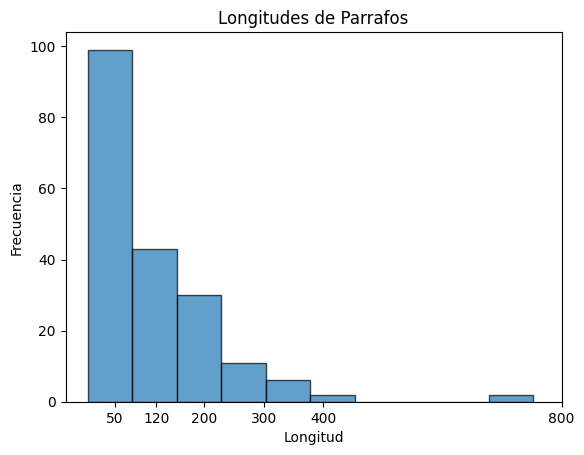

In [5]:
import matplotlib.pyplot as plt
longitudes = [len(texto.split()) for texto in dataset]

bin_edges = plt.hist(longitudes, bins=10, edgecolor='k', alpha=0.7)
plt.xticks([50,120,200,300,400,800], ['50','120','200','300','400','800'])

plt.title('Longitudes de Parrafos')
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.show()

# Tokenización

In [6]:
#Dividimos las oraciones en palabras
words = [word for sentence in dataset for word in sentence.split()]
#nos quedamos con las palabras unicas
unique_words = set(words)

num_words = len(unique_words)

print(f"Cantidad de palabras únicas: {num_words}")

Cantidad de palabras únicas: 4660


In [7]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model, to_categorical, pad_sequences

token=Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n¡-¿»«—', lower=True, split=' ', char_level=False, oov_token="UNK", document_count=0) #Instanciamos el tokenizador
token.fit_on_texts(dataset)                                                                                                                                 # y fiteamos a nuestro dataset

dictionary = token.index_word
vocab_size=len(dictionary)+1
print("Luego de removidos signos de puntuacion, la cantidad real de palabras a tokenizar es:", vocab_size)

Luego de removidos signos de puntuacion, la cantidad real de palabras a tokenizar es: 3501


In [ ]:
dictionary

Genero secuencias para el entrenamiento. Para ello tomo oraciones, las tokenizo, y armo dos listas, una que contenga una oracion menos su ultima palabra y la otra con la palabra que iría a continuación. Esto es similar al caso de tener data con sus respectivos labels. A la vez aprovecho y padeo las secuencias para que tengan el mismo tamaño, y las palabras de salida o labels paso a representarlos como una categoría (one-hot encoding). Con esta idea notamos que para los modelos que se entrenan aqui la dimension de entrada es fija.

In [9]:
tokenized_seqs = token.texts_to_sequences(dataset)  # Tokenizo los textos
max_len=500                                         #Del EDA notamos que los parrafos son de hasta 500 palabras en su gran mayoría, por eso tomamos de tamaño maximo de largo de contexto 500.
x_sequences = []
y_sequences = []
for text in tokenized_seqs:
  for i in range(1,len(text)):
      x_sequences.append(text[:i])  # Arreglos de entrada
      y_sequences.append(text[i])   # Arreglos de salida
x_sequences = pad_sequences(x_sequences, maxlen=max_len, padding='pre', truncating='pre')
y_sequences = to_categorical(y_sequences, num_classes=len(token.index_word)+1)              #Al usar one-hot, usaremos como loss Categorical-Cross



In [37]:
print(x_sequences.shape)
print(y_sequences.shape)

(20612, 500)
(20612, 3501)


In [10]:
#Visualizemos una
print("Para la oracion:")
print(token.sequences_to_texts([x_sequences[13][-6:]])[0])
print("La siguiente palabra sería:")
print(token.index_word[(np.argmax(y_sequences[13]))])


Para la oracion:
después de un sueño intranquilo se
La siguiente palabra sería:
encontró


## Cargamos embeddings pre entrenados
Cargamos los embeddings que provee fasttext para el idioma español

In [11]:
import codecs
#load embeddings
EMBEDDING_DIR = "/content/drive/MyDrive/Colab Notebooks/"
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(EMBEDDING_DIR+'cc.es.300.vec', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 2000000 word vectors


Teniendo los embeddings para las 2M de palabras, ahora procedemos a armar nuestra matriz de embeddings, es decir, nos quedamos con las palabras que figuran en nuestro texto y les damos sus significados semánticos extraidos segun fastText.

Mas info sobre estos en: https://fasttext.cc/docs/en/crawl-vectors.html

In [12]:
embed_dim = 300
embedding_matrix = np.zeros([vocab_size, embed_dim])
for idx, word in dictionary.items():
    if idx < vocab_size and word in embeddings_index:
        embedding_matrix[idx,:] = embeddings_index[word]

# Métricas
En cuanto a las metricas de evaluación mas relevantes para el analisis de performance se consideraron las mencionadas en la fuente referenciada mas arriba, a saber:

Consultando con otros grupos se decidió utilizar la metrica de perplejidad, la cual conceptualmente tiene mucho sentido ya que plantea alimentar al modelo con oraciones reales propias del set de datos y promediar las probabilidades de que acierte correctamente la "respuesta correcta", en este caso la siguiente palabra

In [13]:
def perplexity(model, x_sequences, y_indices, nwords, embedding_matrix):
    perp = np.array([])

    for i in range(len(x_sequences)):
        x_seq = x_sequences[i]
        y_idx = y_indices[i]

        predicted_probs = model.predict(np.array([x_seq]), verbose=0)[0]

        word_prob = predicted_probs[y_idx]

        #sequence_perplexity = 2 ** (-np.log2(word_prob))
        sequence_perplexity = 1 / word_prob
        perp = np.append(perp, sequence_perplexity)

    mean_perplexity = np.mean(perp)

    return mean_perplexity

# Modelos
Con los datos listos, estamos en condiciones de definir nuestros modelos

In [28]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, Conv1D, MaxPooling1D, BatchNormalization, GlobalMaxPooling1D, Dropout, Dense, Lambda, MaxPooling1D, Input, Concatenate, SimpleRNN, Dot, RepeatVector, TimeDistributed, Multiply, Lambda, Flatten, Activation, GRU, Reshape, Bidirectional, LSTM
from keras.layers import Input, Concatenate, Dot, RepeatVector, TimeDistributed, Multiply
from keras.layers import Bidirectional, LSTM, Activation, Reshape, Lambda, Dropout, GRU
from keras.models import Sequential, Model
from keras import optimizers
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.activations import softmax
import keras.backend as K
from keras.utils import plot_model

def softMaxOverTime(x):
    return tf.keras.activations.softmax(x,axis=1)

### a) LSTM

In [56]:
LSTM_dim=100
#vocab_size =3k+ =Cantidad de palabras en mi vocabulario
#Max_len = 500, tamaño del contexto
embed_dim = 300


input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
#LSTM
lstm_out = Bidirectional(LSTM(LSTM_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)
ulog_attention = Dense(1, activation="linear")(lstm_out)

attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention = TimeDistributed(RepeatVector(LSTM_dim))(attention)
repeated_attention = Reshape([max_len, LSTM_dim])(repeated_attention)

weighted_embeddings = Multiply()([repeated_attention, lstm_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

dense1 = Dense(256, activation='relu')(embedding_sum)
dense2 = Dense(128, activation='relu')(dense1)
dense_out = Dense(vocab_size, activation='softmax')(dense2)              #Elige entre las 3k palabras posibles

modelLSTM = Model(input_layer, dense_out)
adam = optimizers.Adam(learning_rate=0.01)
modelLSTM.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['categorical_crossentropy'])
modelLSTM.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 500)]                0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 500, 300)             1050300   ['input_16[0][0]']            
                                                                                                  
 bidirectional_11 (Bidirect  (None, 500, 100)             320800    ['embedding_13[0][0]']        
 ional)                                                                                           
                                                                                                  
 dense_34 (Dense)            (None, 500, 1)               101       ['bidirectional_11[0][0]

In [57]:
import tensorflow.keras.callbacks as callbacks
#Defino callbacks utiles
early_cb = callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=5,
                                   start_from_epoch=12)

plateu_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.05,
                                          patience=3)


In [58]:
hist = modelLSTM.fit(x=x_sequences,y=y_sequences,batch_size=256,epochs=40,validation_split=0.1, callbacks = [early_cb, plateau_cb])

Epoch 1/40
73/73 [==============================] - 41s 493ms/step - loss: 6.5940 - categorical_crossentropy: 6.5940 - accuracy: 0.0453 - val_loss: 6.5420 - val_categorical_crossentropy: 6.5420 - val_accuracy: 0.0500 - lr: 0.0100
Epoch 2/40
73/73 [==============================] - 35s 489ms/step - loss: 6.1859 - categorical_crossentropy: 6.1859 - accuracy: 0.0490 - val_loss: 6.4970 - val_categorical_crossentropy: 6.4970 - val_accuracy: 0.0538 - lr: 0.0100
Epoch 3/40
73/73 [==============================] - 32s 441ms/step - loss: 5.9567 - categorical_crossentropy: 5.9567 - accuracy: 0.0567 - val_loss: 6.4147 - val_categorical_crossentropy: 6.4147 - val_accuracy: 0.0567 - lr: 0.0100
Epoch 4/40
73/73 [==============================] - 36s 503ms/step - loss: 5.7696 - categorical_crossentropy: 5.7696 - accuracy: 0.0653 - val_loss: 6.3914 - val_categorical_crossentropy: 6.3914 - val_accuracy: 0.0587 - lr: 0.0100
Epoch 5/40
73/73 [==============================] - 36s 505ms/step - loss: 5.556

In [1]:
perplexity = perplexity(modelLSTM, x_sequences[:100], y_sequences[:100], vocab_size, embedding_matrix)
print("Perplejidad del modelo:", perplexity)

NameError: ignored

### b) CNN

In [ ]:
value_dim=100

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
#CNN
cnn_out = (Conv1D(value_dim, kernel_size=3, activation="relu", padding="same"))(embedding_layer)
ulog_attention = Dense(1, activation="linear")(cnn_out)
attention = Activation(softMaxOverTime)(ulog_attention)
repeated_attention = TimeDistributed(RepeatVector(value_dim))(attention)
repeated_attention = Reshape([max_len, value_dim])(repeated_attention)
weighted_embeddings = Multiply()([repeated_attention, cnn_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

dense1 = Dense(256, activation='relu')(embedding_sum)
dense2 = Dense(128, activation='relu')(dense1)
dense_out = Dense(vocab_size, activation='softmax')(dense2)              #Elige entre las 3k palabras posibles

modelCNN = Model(input_layer, dense2)
adam = optimizers.Adam(learning_rate=0.01)
modelCNN.compile(loss='categorical_crossentropy',
                 optimizer=adam,
                 metrics=['categorical_crossentropy'])


In [ ]:
early_cb = callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=5,
                                   start_from_epoch=12)

plateu_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.05,
                                          patience=3)

In [ ]:
hist = modelCNN.fit(x_sequences,y_sequences,batch_size=256,epochs=40,validation_split=0.1, callbacks = [early_cb, plateau_cb])

In [ ]:
perplexity = perplexity(modelCNN, x_sequences[:100], y_sequences[:100], vocab_size, embedding_matrix)
print("Perplejidad del modelo:", perplexity)

### c) GRU

In [ ]:
value_dim=100

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(vocab_size, embed_dim, input_length=max_len, trainable=False)(input_layer)
#GRU
gru_out = Bidirectional(GRU(value_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)

ulog_attention = Dense(1, activation="linear")(gru_out)
attention = Activation(softMaxOverTime)(ulog_attention)
repeated_attention = TimeDistributed(RepeatVector(value_dim))(attention)
repeated_attention = Reshape([max_len, value_dim])(repeated_attention)
weighted_embeddings = Multiply()([repeated_attention, gru_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

dense1 = Dense(256, activation='relu')(embedding_sum)
dense2 = Dense(128, activation='relu')(dense1)
dense_out = Dense(vocab_size, activation='softmax')(dense2)              #Elige entre las 3k palabras posibles

modelGRU = Model(input_layer, dense2)
adam = optimizers.Adam(learning_rate=0.001)
modelGRU.compile(loss='categorical_crossentropy',
                 optimizer=adam,
                 metrics=['categorical_crossentropy'])

In [ ]:
early_cb = callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=5,
                                   start_from_epoch=12)

plateu_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.05,
                                          patience=3)
hist = modelGRU.fit(x_sequences,y_sequences,batch_size=256,epochs=40,validation_split=0.1, callbacks = [early_cb, plateau_cb])

In [ ]:
perplexity = perplexity(modelGRU, x_sequences[:100], y_sequences[:100], vocab_size, embedding_matrix)
print("Perplejidad del modelo:", perplexity)

# Generación
Se además de evaluar la metrica de perplejidad se probaron las capacidades de generacion de los 3 modelos entrenados. En este caso se probaron 2 funciones distintas, por un lado se tomó una implementación para el algoritmo "Greedy Search" y por otro "Beam Search".

Una fuente que resultó útil para entenderlos fue: https://medium.com/@jessica_lopez/understanding-greedy-search-and-beam-search-98c1e3cd821d

Las implementaciones presentadas en este trabajo fueron tomadas del grupo Basili-Wahle, quienes no solo accedieron a su uso sino que tambien colaboraron a su vez en entender algunas cuestiones particulares a las mismas.

#Greedy Search con Arg-Max

In [ ]:
def greedy(seed_phrase, token, model, pred_len=25, max_len=500, stopper="> sep"):
  stop_token = token.texts_to_sequences([stopper])[0]
  seed_text = token.texts_to_sequences([seed_phrase])[0]
  pred_arr = []

  for _ in range(pred_len):
    # Concatenamos y paddeamos
    aux = np.concatenate((seed_text, pred_arr))
    padded = pad_sequences([aux], maxlen=max_len)

    # Predecimos
    pred_idx = np.argmax(model.predict(padded, verbose=0)[0])

    if pred_idx in stop_token:  # La prediccion hasta un stop_char
      break

    pred_arr = np.append(pred_arr, [int(pred_idx)])


  return token.sequences_to_texts([pred_arr])[0]

In [ ]:
seed= "< el siguiente"
prediction = greedy(seed, token, model, pred_len=25)
print(seed, prediction)

#Greedy Search + Temperatura

In [ ]:
import random

def greedyTemp(seed_phrase, token, model, temp=1, pred_len=25, max_len=500, stopper=[">", "sep"]):
  stop_token = token.texts_to_sequences(stopper)[0]
  seed_text = token.texts_to_sequences([seed_phrase])[0]
  pred_arr = []

  for _ in range(pred_len):
    # Concatenamos y paddeamos
    aux = np.concatenate((seed_text, pred_arr))
    padded = pad_sequences([aux], maxlen=max_len)

    # Predecimos considerando temperatura y elegimos de forma semialeatoria
    probs = (model.predict(padded, verbose=0)[0])**(1/temp)
    pred_idx = random.choices(range(len(probs)), weights=probs, k=1)

    if pred_idx in stop_token:
      break

    # Agregamos el nuevo token a la prediccion
    pred_arr = np.append(pred_arr, [pred_idx])

  return token.sequences_to_texts([pred_arr])[0]

In [ ]:
seed= "< el siguiente"
prediction = greedyTemp(seed, token, model, temp=1.25, pred_len=25)
print(seed, prediction)


#Stochastic Beam Search

In [ ]:
import numpy as np
import random

def stochastic_beam_search(seed_phrase, token, n_beam=3, temp=1.0, pred_len=20):
    seqs = token.texts_to_sequences([seed_phrase])
    probs = [1]

    for paso in range(pred_len):
        new_seqs = []
        new_probs = []

        for i in range(len(seqs)):
            padded = pad_sequences([seqs[i]], maxlen=max_len)
            # Generar prediccion y aplicar temp
            pred_probs = (model.predict(padded, verbose=0)[0])**(1/temp)

            # Elegir N opciones en base a sus probs
            pred_idx = random.choices(range(len(pred_probs)), weights=pred_probs, k=n_beam)

            # Appendear token predichos y sus probs calculadas
            for idx in pred_idx:
              new_seqs.append(seqs[i]+[idx])
              new_probs.append(probs[i]*pred_probs[idx])

        # Actualizamos
        seqs = new_seqs
        probs = new_probs

    likely_idx = probs.index(max(probs)) # Me quedo con la opcion mas probable

    #Devuelvo la prediccion (sin la seed) en formato texto
    return token.sequences_to_texts([seqs[likely_idx]])[0]

In [ ]:

seed= "< el siguiente"
prediction = stochastic_beam_search(seed, token, n_beam=3, temp=1, pred_len=5)
print(prediction)

In [ ]:

seed= "< el siguiente"
prediction = stochastic_beam_search(seed, token, n_beam=3, temp=2, pred_len=5)      #Variamos la temperatura
print(prediction)